In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

# Dask start

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37875")
client

<Client: 'tcp://127.0.0.1:37875' processes=4 threads=8, memory=29.40 GiB>

# Import

In [4]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import xesmf as xe
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe

# Load data

Choose cases

In [5]:
data=[dict(),dict()]

In [6]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'Gulf Stream'})
data[1] = dict({'region' : '2', 'season' : 'fma', 'label' : 'Acores'})

## eNATL60

In [7]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [8]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,50),y=y_slice,x=x_slice)  # take every 50-th hourly output
coord_slice = dict(y=y_slice,x=x_slice)

In [9]:
nb_of_time_chunks = 7

In [10]:
%%time
for i in range(len(data)) :
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.load()
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set

CPU times: user 1.15 s, sys: 400 ms, total: 1.55 s
Wall time: 1min 3s


## Time-averaged eNATL60

In [11]:
resampling_avg_period = '2200h'  # 40 days

In [12]:
%%time
for i in range(len(data)) :
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    #current_set = current_set.mean(dim='time_counter')
    #current_set = current_set.isel(data_slice)
    #current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.load()
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR_avg'] = current_set

CPU times: user 471 ms, sys: 95.9 ms, total: 567 ms
Wall time: 1min 9s


## eORCA025

In [13]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_dataset("Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    rename(nav_lat='lat', nav_lon='lon')

# Compare

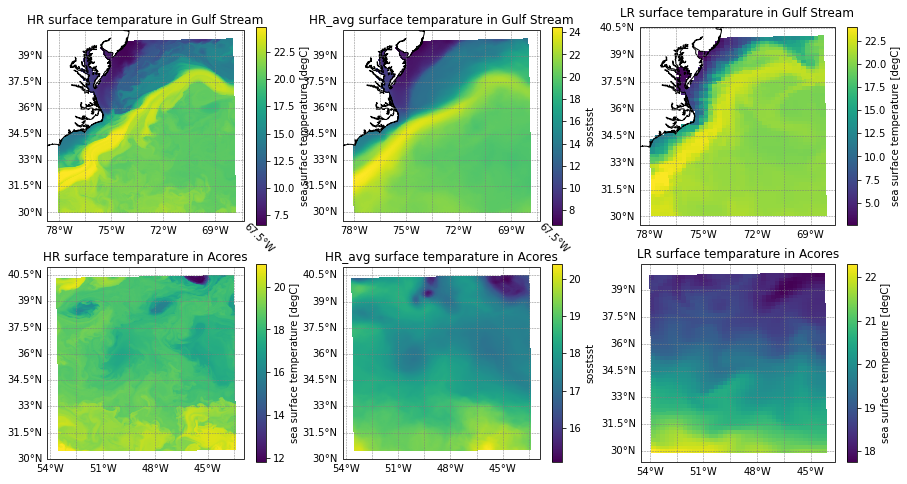

In [14]:
fig, axis = plt.subplots(ncols=3, nrows=2, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
for region in [0,1] :
    for col, dataSetKey in enumerate(['HR', 'HR_avg','LR']) :
        row = region 
        data[region][dataSetKey].isel(time_counter=0).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=dataSetKey + ' surface temparature in ' + data[region]['label'])

for ax in axis.flatten() :
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

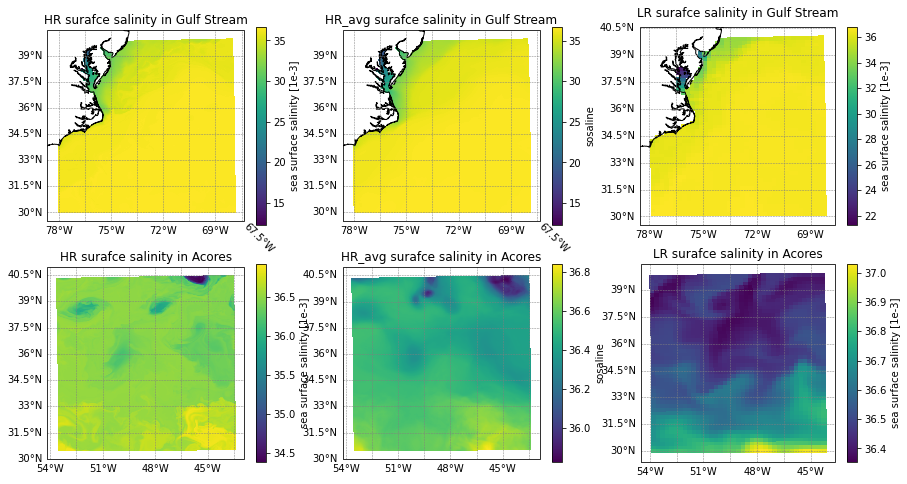

In [15]:
fig, axis = plt.subplots(ncols=3, nrows=2, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
for region in [0,1] :
    for col, dataSetKey in enumerate(['HR', 'HR_avg', 'LR']) :
        row = region 
        data[region][dataSetKey].isel(time_counter=0).sosaline[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=dataSetKey + ' surafce salinity in ' + data[region]['label'])

for ax in axis.flatten() :
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# Filter

Parameters (to determine) :

In [16]:
filter_coef = 36      # filter coefficient (size gaussian kernel relative to the grid size)
coarsening_window_size=12

In [17]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    new_e2t = data['e2t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    return result

In [18]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    wet_mask = xr.DataArray(dataHR.tmask, dims=['y','x'])
    area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=dataHR.coords)
        data_filtered = gaussian_filter.apply(dataHR, dims=['y', 'x'])
    else :
        data_filtered = dataHR
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

# Downgraded data

## Without time averaging

In [19]:
%%time
for i in [0,1] : 
    data[i]['HR_Filtered'] = apply_filter_downsample(data[i]['HR'], filter_coef, coarsening_window_size).compute().\
    chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

CPU times: user 3min 26s, sys: 2min 38s, total: 6min 5s
Wall time: 6min 3s


In [20]:
%%time
for i in [0,1] : 
    data[i]['HR_Coarsened'] = apply_filter_downsample(data[i]['HR'], 0, coarsening_window_size).compute().\
    chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

CPU times: user 1.03 s, sys: 384 ms, total: 1.41 s
Wall time: 1.41 s


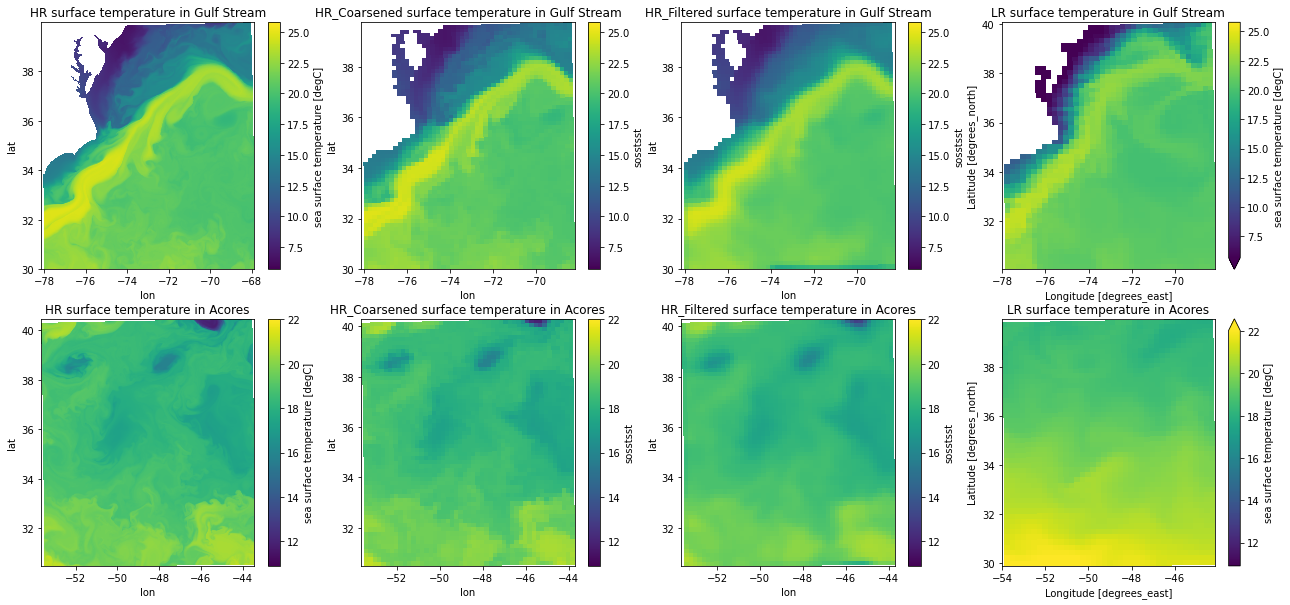

In [21]:
fig, axis = plt.subplots(ncols=4, nrows=2, figsize=(22,10))
for region in [0,1] :
    norm = colors.Normalize(vmin=data[region]['HR_Coarsened'].isel(time_counter=0).sosstsst.min().values-1, \
                            vmax=data[region]['HR_Coarsened'].isel(time_counter=0).sosstsst.max().values+1)
    for col, dataSetKey in enumerate(['HR', 'HR_Coarsened', 'HR_Filtered', 'LR']) :
        row = region 
        data[region][dataSetKey].isel(time_counter=0).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col], norm=norm)
        axis[row,col].set(title=dataSetKey + ' surface temperature in ' + data[region]['label'])

## With time averaging

In [22]:
%%timeit 
for i in [0,1] : 
    data[i]['HR_Avg_Filtered'] = apply_filter_downsample(data[i]['HR_avg'], filter_coef, coarsening_window_size).compute().\
    chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

30.7 s ± 641 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit
for i in [0,1] : 
    data[i]['HR_Avg_Coarsened'] = apply_filter_downsample(data[i]['HR_avg'], 0, coarsening_window_size).compute().\
    chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

422 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


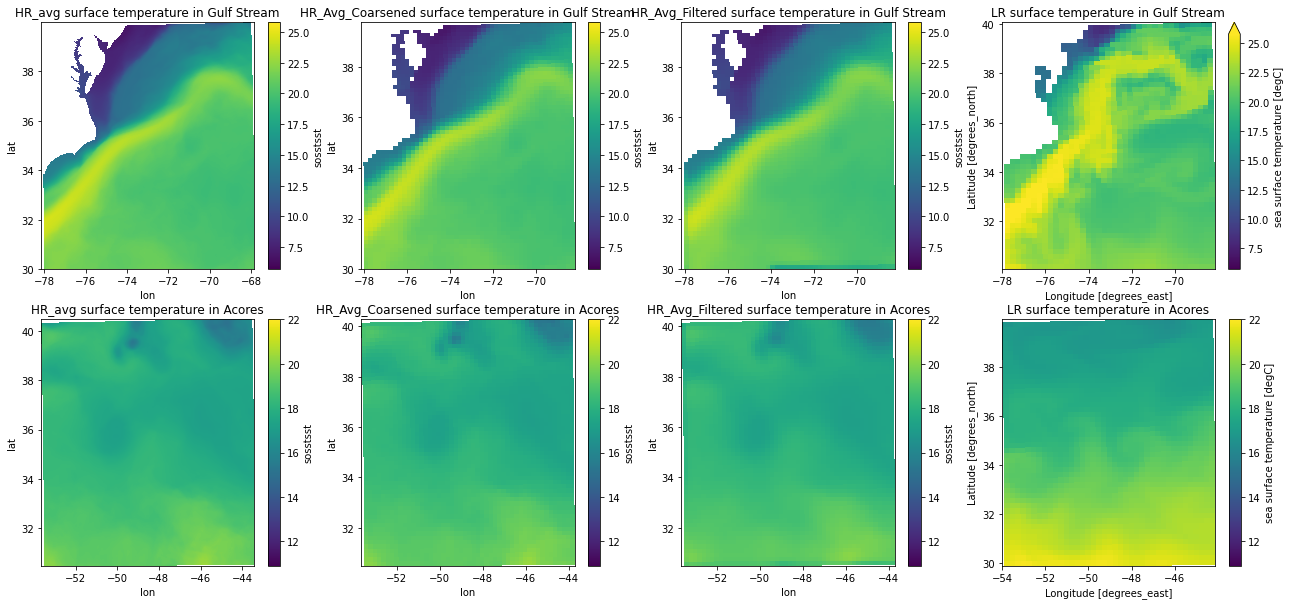

In [24]:
fig, axis = plt.subplots(ncols=4, nrows=2, figsize=(22,10))
for region in [0,1] :
    norm = colors.Normalize(vmin=data[region]['HR_Coarsened'].isel(time_counter=0).sosstsst.min().values-1, \
                            vmax=data[region]['HR_Coarsened'].isel(time_counter=0).sosstsst.max().values+1)
    for col, dataSetKey in enumerate(['HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered', 'LR']) :
        row = region 
        data[region][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col], norm=norm)
        axis[row,col].set(title=dataSetKey + ' surface temperature in ' + data[region]['label'])

# Histograms of temperature and salinity

In [25]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t).where(dataSet.tmask >0), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum()).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = hist/hist.sum()
    return norm_hist

In [26]:
nb_of_bins = 150

In [27]:
%%timeit
for region in [0,1] :
    for dataSetKey in ['HR', 'HR_Coarsened', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered'] :
        new_key = dataSetKey + '_hist_temp_sal'
        data[region][new_key] = compute_2D_histogram(data[region][dataSetKey].\
                                                           chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), 'sosaline', 'sosstsst', nb_of_bins).compute()

7.2 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, cmap, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmap, shading='auto', alpha=0.95)
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x)
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins])
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

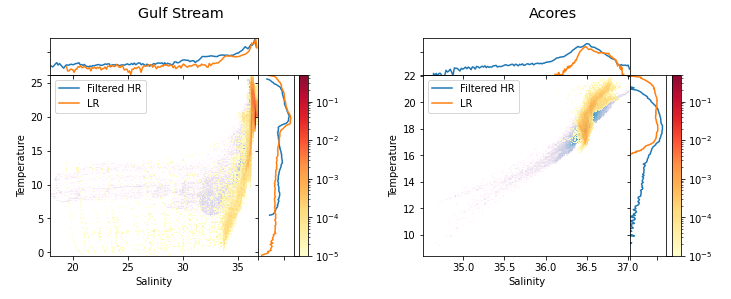

In [74]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for region in [0,1] :
    subfigs[region].suptitle(data[region]['label'], fontsize='x-large')
    sel_data0 = data[region]['HR_Filtered_hist_temp_sal']
    #sel_data1 = data[region]['Avg_Filtered_hist_temp_sal']
    sel_data1 = data[region]['LR_hist_temp_sal']
    big_ax = subfigs[region].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[region].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[region].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[region].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data0,'PuBuGn', 'sosaline_bin', 'sosstsst_bin', top_ax, right_ax, big_ax)
    #margin_hist(sel_data1, 'YlOrRd', 'sosaline_bin', 'sosstsst_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data1, 'YlOrRd', 'sosaline_bin', 'sosstsst_bin', top_ax, right_ax, big_ax)
    big_ax.set(xlabel='Salinity', ylabel='Temperature')
    big_ax.legend(handles=top_ax.lines, labels=['Filtered HR', 'LR'], loc='upper left')

    subfigs[region].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

# Histograms of gradients

In [32]:
x_slice = slice(0,-1)
y_slice = slice(2,-1)

bord_cut = dict(y=y_slice,x=x_slice)

In [33]:
def gradx(dataArray, delta_x) :
    return (dataArray.shift(x=-1) - dataArray)/delta_x
def grady(dataArray, delta_y) :
    return (dataArray.shift(y=-1) - dataArray)/delta_y

In [34]:
def add_spatial_grad_to_dataset(input_dataset) :
    return xr.merge([input_dataset,
                      xr.DataArray(gradx(input_dataset.sosstsst, input_dataset.e1t), name='gradx_temp'),
                      xr.DataArray(grady(input_dataset.sosstsst, input_dataset.e2t), name='grady_temp'),
                      xr.DataArray(gradx(input_dataset.sosaline, input_dataset.e1t), name='gradx_sal'),
                      xr.DataArray(grady(input_dataset.sosaline, input_dataset.e2t), name='grady_sal'),                      
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosstsst, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosstsst, input_dataset.e2t)**2), name='grad_temp'),
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosaline, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosaline, input_dataset.e2t)**2), name='grad_sal')],compat='override')

In [75]:
%%time
for region in [0,1] :
    for dataSetKey in ['HR', 'HR_Coarsened', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered'] :
        data[region][dataSetKey] = add_spatial_grad_to_dataset(data[region][dataSetKey][bord_cut]).compute().chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

CPU times: user 9.63 s, sys: 4.67 s, total: 14.3 s
Wall time: 25.3 s


In [76]:
%%time
for region in [0,1] :
    new_key = 'HR_Coarsened_hist_grads'
    data[region][new_key] = compute_2D_histogram(data[region]['HR_Coarsened'], 'grad_sal', 'grad_temp', nb_of_bins).compute()
    for dataSetKey in ['HR', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered'] :
        new_key = dataSetKey + '_hist_grads'
        bins = [data[region]['HR_Coarsened_hist_grads'].grad_sal_bin.values, data[region]['HR_Coarsened_hist_grads'].grad_temp_bin.values]
        data[region][new_key] = compute_2D_histogram(data[region][dataSetKey], 'grad_sal', 'grad_temp', nb_of_bins, bins=bins).compute()

CPU times: user 997 ms, sys: 176 ms, total: 1.17 s
Wall time: 3.81 s


In [77]:
%%time
# Gadients in x-direction
for region in [0,1] :
    new_key = 'HR_Coarsened_hist_grads_x'
    data[region][new_key] = compute_2D_histogram(data[region]['HR_Coarsened'], 'gradx_sal', 'gradx_temp', nb_of_bins).compute()
    for dataSetKey in ['HR', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered']  :
        new_key = dataSetKey + '_hist_grads_x'
        bins = [data[region]['HR_Coarsened_hist_grads_x'].gradx_sal_bin.values, data[region]['HR_Coarsened_hist_grads_x'].gradx_temp_bin.values]
        data[region][new_key] = compute_2D_histogram(data[region][dataSetKey], 'gradx_sal', 'gradx_temp', nb_of_bins, bins=bins).compute()

CPU times: user 1.01 s, sys: 174 ms, total: 1.18 s
Wall time: 3.73 s


In [78]:
%%time
# Gadients in y-direction
for region in [0,1] :
    new_key = 'HR_Coarsened_hist_grads_y'
    data[region][new_key] = compute_2D_histogram(data[region]['HR_Coarsened'], 'grady_sal', 'grady_temp', nb_of_bins).compute()
    for dataSetKey in  ['HR', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered']  :
        new_key = dataSetKey + '_hist_grads_y'
        bins = [data[region]['HR_Coarsened_hist_grads_y'].grady_sal_bin.values, data[region]['HR_Coarsened_hist_grads_y'].grady_temp_bin.values]
        data[region][new_key] = compute_2D_histogram(data[region][dataSetKey], 'grady_sal', 'grady_temp', nb_of_bins, bins=bins).compute()

CPU times: user 1.02 s, sys: 168 ms, total: 1.18 s
Wall time: 3.81 s


## Norms of gradients

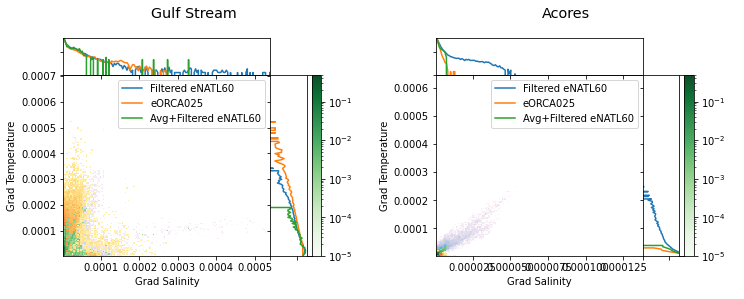

In [79]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for region in [0,1] :
    subfigs[region].suptitle(data[region]['label'], fontsize='x-large')
    sel_data1 = data[region]['HR_Filtered_hist_grads']
    sel_data2 = data[region]['LR_hist_grads']
    sel_data3 = data[region]['HR_Avg_Filtered_hist_grads']
    big_ax = subfigs[region].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[region].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[region].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[region].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data1,'PuBuGn', 'grad_sal_bin', 'grad_temp_bin', top_ax, right_ax, big_ax)
    margin_hist(sel_data2,'YlOrRd', 'grad_sal_bin', 'grad_temp_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data3, 'Greens', 'grad_sal_bin', 'grad_temp_bin', top_ax, right_ax, big_ax)
    big_ax.set(xlabel='Grad Salinity', ylabel='Grad Temperature')
    big_ax.legend(handles=top_ax.lines, labels=['Filtered eNATL60', 'eORCA025', 'Avg+Filtered eNATL60'], loc='best')
    subfigs[region].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

## Gradients in X-direction

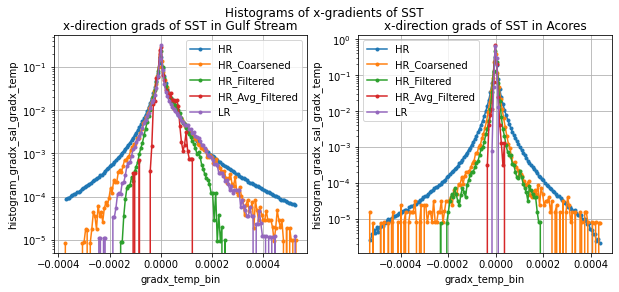

In [82]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
fig.suptitle('Histograms of x-gradients of SST')
for region in [0,1] :
    for dataSetKey in ['HR', 'HR_Coarsened', 'HR_Filtered', 'HR_Avg_Filtered', 'LR'] :
        new_key = dataSetKey + '_hist_grads_x'
        data[region][new_key].sum(dim='gradx_sal_bin').plot(ax=ax[region], label=dataSetKey, ls='-', marker='.')
    ax[region].set(title='x-direction grads of SST in ' + data[region]['label'], yscale='log'); ax[region].grid(True)
    ax[region].legend()

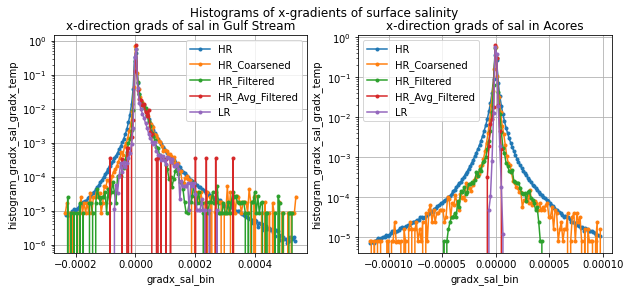

In [83]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
fig.suptitle('Histograms of x-gradients of surface salinity')
for region in [0,1] :
    for dataSetKey in ['HR', 'HR_Coarsened', 'HR_Filtered', 'HR_Avg_Filtered', 'LR'] :
        new_key = dataSetKey + '_hist_grads_x'
        data[region][new_key].sum(dim='gradx_temp_bin').plot(ax=ax[region], label=dataSetKey, ls='-', marker='.')
    ax[region].set(title='x-direction grads of sal in ' + data[region]['label'], yscale='log'); ax[region].grid(True)
    ax[region].legend()

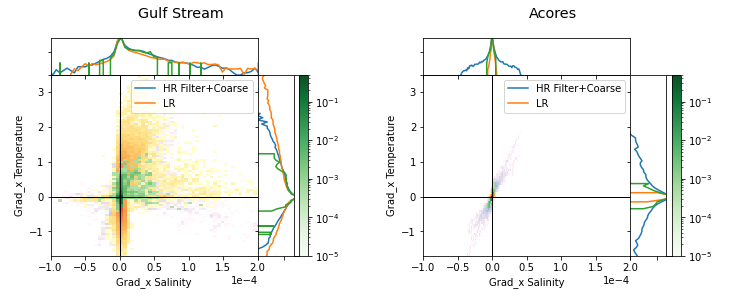

In [86]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for region in [0,1] :
    subfigs[region].suptitle(data[region]['label'], fontsize='x-large')
    sel_data1 = data[region]['HR_Filtered_hist_grads_x']
    sel_data15 = data[region]['HR_Avg_Filtered_hist_grads_x']
    sel_data2 = data[region]['LR_hist_grads_x']
    big_ax = subfigs[region].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[region].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[region].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[region].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data1,'PuBuGn', 'gradx_sal_bin', 'gradx_temp_bin', top_ax, right_ax, big_ax)
    margin_hist(sel_data2, 'YlOrRd', 'gradx_sal_bin', 'gradx_temp_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data15,'Greens', 'gradx_sal_bin', 'gradx_temp_bin', top_ax, right_ax, big_ax)
    big_ax.set(xlabel='Grad_x Salinity', ylabel='Grad_x Temperature')
    big_ax.ticklabel_format(useOffset=False, scilimits=(-4,6))
    big_ax.legend(handles=top_ax.lines, labels=['HR Filter+Coarse', 'LR'], loc='best')
    big_ax.axvline(x=0, color='k', lw=1); big_ax.axhline(y=0, color='k', lw=1)
    big_ax.set(xlim=[-0.0001, 0.0002], ylim=[-0.00017, 0.00035])

    subfigs[region].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

## Gradients in Y-direction

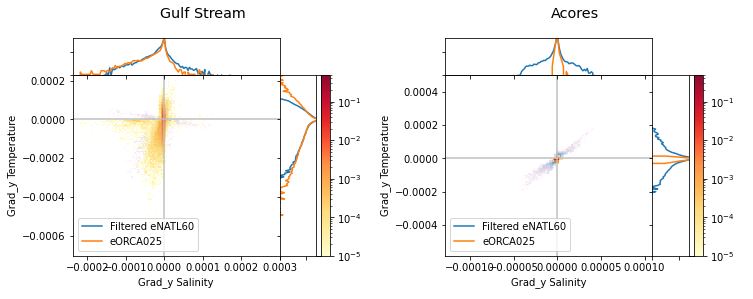

In [87]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for region in [0,1] :
    subfigs[region].suptitle(data[region]['label'], fontsize='x-large')
    sel_data1 = data[region]['HR_Filtered_hist_grads_y']
    sel_data2 = data[region]['LR_hist_grads_y']
    big_ax = subfigs[region].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[region].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[region].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[region].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data1,'PuBuGn', 'grady_sal_bin', 'grady_temp_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 'YlOrRd', 'grady_sal_bin', 'grady_temp_bin', top_ax, right_ax, big_ax)
    big_ax.set(xlabel='Grad_y Salinity', ylabel='Grad_y Temperature')
    big_ax.legend(handles=top_ax.lines, labels=['Filtered eNATL60', 'eORCA025'], loc='lower left')
    big_ax.axvline(x=0, color='silver', lw=1.5); big_ax.axhline(y=0, color='silver', lw=1.5)

    subfigs[region].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

# Statistical moments of gradients

In [88]:
keys = ['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']

In [89]:
%%time
for region in [0,1] :
    for dataSetKey in ['HR', 'HR_Coarsened', 'HR_Filtered', 'LR', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered'] :
        curDS = data[region][dataSetKey + '_hist_grads_x']
        [curDS.attrs['nobs'], curDS.attrs['minmax'], curDS.attrs['mean'], curDS.attrs['variance'], curDS.attrs['skewness'], curDS.attrs['kurtosis']] \
        = describe(data[region][dataSetKey].gradx_temp, axis=None, nan_policy='omit')

        curDS = data[region][dataSetKey + '_hist_grads_y']
        [curDS.attrs['nobs'], curDS.attrs['minmax'], curDS.attrs['mean'], curDS.attrs['variance'], curDS.attrs['skewness'], curDS.attrs['kurtosis']] \
        = describe(data[region][dataSetKey].grady_temp, axis=None, nan_policy='omit')

CPU times: user 10.2 s, sys: 3.01 s, total: 13.2 s
Wall time: 14.4 s


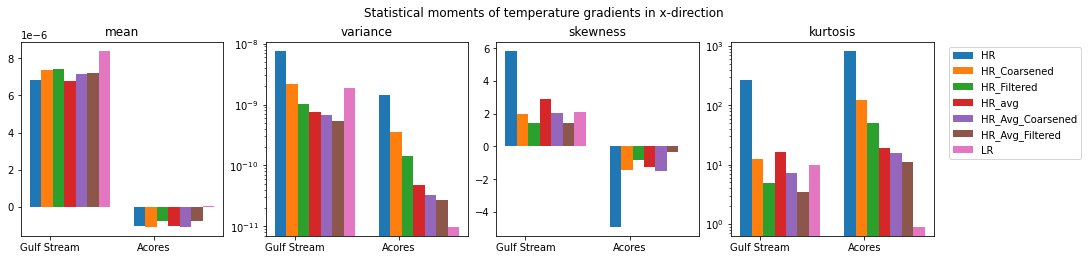

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Statistical moments of temperature gradients in x-direction')
x = np.arange(2)
bar_width = 0.11
for index, stat_moment_key in enumerate(['mean', 'variance', 'skewness', 'kurtosis']) :
    for bar_shift, dsKey in enumerate(['HR', 'HR_Coarsened', 'HR_Filtered', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered',  'LR',]) :
        ax[index].bar(x+bar_shift*bar_width, [data[region][dsKey+'_hist_grads_x'].attrs[stat_moment_key] for region in [0,1]], width=bar_width, label=dsKey)
    ax[index].set_xticks(x + 1.25*bar_width)
    ax[index].set_xticklabels([data[region]['label'] for region in [0,1]])
    ax[index].set(title=stat_moment_key)
    if (index%2 == 1) : ax[index].set(yscale='log')
    if (index%2 == 0) : ax[index].set(yscale='linear')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

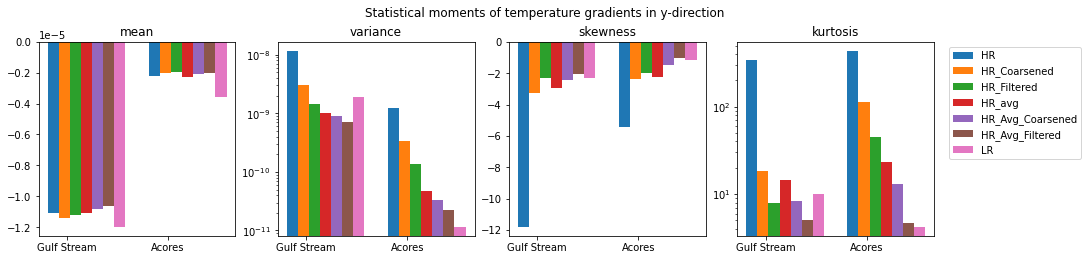

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Statistical moments of temperature gradients in y-direction')
x = np.arange(2)
bar_width = 0.11
for index, stat_moment_key in enumerate(['mean', 'variance', 'skewness', 'kurtosis']) :
    for bar_shift, dsKey in enumerate(['HR', 'HR_Coarsened', 'HR_Filtered', 'HR_avg', 'HR_Avg_Coarsened', 'HR_Avg_Filtered', 'LR']) :
        ax[index].bar(x+bar_shift*bar_width, [data[region][dsKey+'_hist_grads_y'].attrs[stat_moment_key] for region in [0,1]], width=bar_width, label=dsKey)
    ax[index].set_xticks(x + 1.25*bar_width)
    ax[index].set_xticklabels([data[region]['label'] for region in [0,1]])
    ax[index].set(title=stat_moment_key)
    if (index%2 == 1) : ax[index].set(yscale='log')
    if (index%2 == 0) : ax[index].set(yscale='linear')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Structure functions

In [48]:
# TODO : solve the problem with comparison of length scales between different data sets

In [49]:
def compute_structure_functions(dataArr, key_field) :
    N = len(dataArr['x'])
    vectorS1 = np.zeros(N//2-1)
    vectorS2 = np.zeros(N//2-1)
    vectorS3 = np.zeros(N//2-1)
    distance = np.zeros(N//2-1)
    for index,index_shift in enumerate(range(1,N//2)) :
        cut=slice(1,N-index_shift)
        shiftedArr = dataArr[key_field].roll(x=-index_shift,roll_coords=False)
        difference = dataArr[key_field][cut] - shiftedArr[cut]
        vectorS1[index] = difference.mean().values
        vectorS2[index] = (difference**2).mean().values
        vectorS3[index] = (difference**3).mean().values
        distance[index] = dataArr.isel(x=slice(0,index_shift)).e1t.sum(dim='x').mean(dim='y').values
    stucture_functions_dataset = xr.Dataset(data_vars={'S1' : xr.DataArray(vectorS1, dims=["shift"]),\
                                             'S2' : xr.DataArray(vectorS2, dims=["shift"]),\
                                             'S3' : xr.DataArray(vectorS3, dims=["shift"])}, \
                                            coords={'shift' : np.arange(1,N//2),\
                                                   'shift_distance' : ('shift', distance/1000)})
    return stucture_functions_dataset

In [50]:
def difference_with_shifted(dataSet, variable, nb_points_shift=1) :
    N = len(dataSet['x'])
    cut=slice(0,N-nb_points_shift)
    shiftedArr = dataSet[variable].roll(x=-nb_points_shift,roll_coords=False)
    difference = dataSet[variable][cut] - shiftedArr[cut]
    return difference

In [51]:
#cut_slice = slice(1,-nb_points_shift)

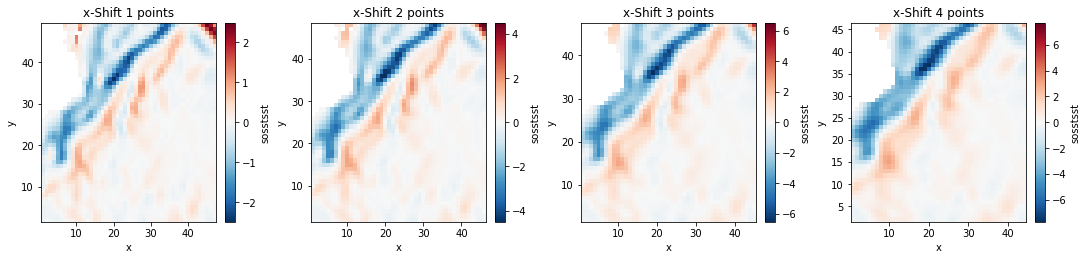

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True, figsize=(15, 3.5))
for nb_points_shift in range(1,5) :
    difference_with_shifted(data[0]['HR_Filtered'], 'sosstsst',nb_points_shift=nb_points_shift).isel(time_counter=0, x=slice(1,-nb_points_shift)).plot(ax=ax[nb_points_shift-1])
    ax[nb_points_shift-1].set(title='x-Shift ' + str(nb_points_shift) + ' points')

In [53]:
def str_func_histogram_2d(nb_points_shift, dataSet, nb_of_bins, bins=None) :
    cut_slice = slice(1,-nb_points_shift)
    dataSet['diff_temp_'+str(nb_points_shift)] = difference_with_shifted(dataSet, 'sosstsst', nb_points_shift=nb_points_shift)
    dataSet['diff_sal_'+str(nb_points_shift)] = difference_with_shifted(dataSet, 'sosaline', nb_points_shift=nb_points_shift)
    histo = compute_2D_histogram(dataSet.isel(x=cut_slice), 'diff_sal_'+str(nb_points_shift), 'diff_temp_'+str(nb_points_shift), nb_of_bins, bins=None) 
    return histo

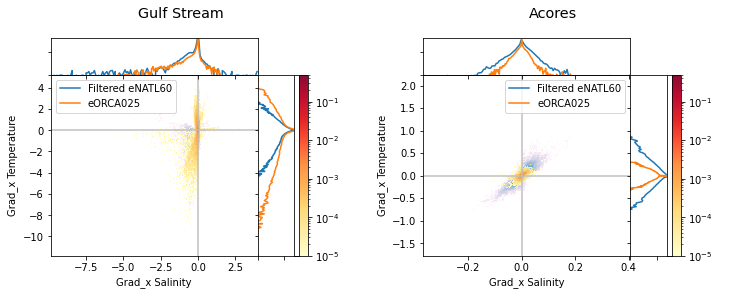

In [54]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
x_var = 'diff_sal_1_bin'
y_var = 'diff_temp_1_bin'
for region in [0,1] :
    subfigs[region].suptitle(data[region]['label'], fontsize='x-large')
    sel_data1 = str_func_histogram_2d(1, data[region]['HR_Filtered'], nb_of_bins, bins=None)
    sel_data2 = str_func_histogram_2d(1, data[region]['LR'], nb_of_bins, bins=None) 
    big_ax = subfigs[region].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[region].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[region].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[region].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data1,'PuBuGn', x_var, y_var, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 'YlOrRd', x_var, y_var, top_ax, right_ax, big_ax)
    big_ax.set(xlabel='Grad_x Salinity', ylabel='Grad_x Temperature')
    big_ax.legend(handles=top_ax.lines, labels=['Filtered eNATL60', 'eORCA025'], loc='best')
    big_ax.axvline(x=0, color='silver', lw=1.5); big_ax.axhline(y=0, color='silver', lw=1.5)

    subfigs[region].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

# Density anomaly